In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.optim import Optimizer

In [2]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00


In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

**Data**

In [4]:
# Скачиваем датасет, дальше смотрим как он выглядит внутри
train = torchvision.datasets.MNIST('./mnist/', train=True, download=True, transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.MNIST('./mnist/', train=False, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 114254456.04it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 79957553.68it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25866660.42it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14631742.53it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [5]:
# Разбиваем трэйновый датасет: 80% - трэйновый, 20% - валидационный
train_size = int(0.8 * len(train))
val_size = len(train) - train_size
train, val = torch.utils.data.random_split(train, [train_size, val_size])

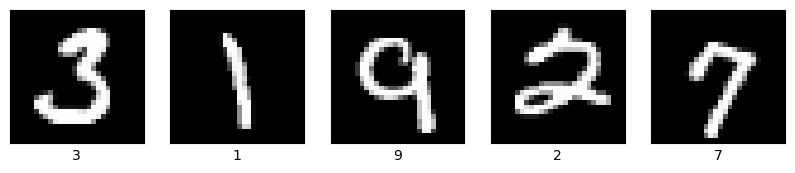

In [6]:
# Смотрим, что внутри датасета и визуализируем
cols, rows = 5, 1
fig = plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols):
  for j in range(rows):
    random_index = np.random.randint(0, len(train))
    ax = fig.add_subplot(rows, cols, i * rows + j + 1)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(train[random_index][0].squeeze(0).numpy().reshape([28, 28]), cmap='gray')
    ax.set_xlabel(train[random_index][1])
plt.show()

In [7]:
train_loader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=64)
val_loader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=1024)
test_loader = torch.utils.data.DataLoader(test, shuffle=False, batch_size=10000)

**Models**

In [18]:
class FCNNNet(nn.Module):
  def __init__(self, in_features, hide_neurons, out_size):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features, hide_neurons),
        nn.ReLU(),
        nn.Linear(hide_neurons, hide_neurons // 2),
        nn.ReLU(),
        nn.Linear(hide_neurons // 2, hide_neurons // 4),
        nn.ReLU(),
        nn.Linear(hide_neurons // 4, out_size),
        #nn.Softmax()
    )

  def forward(self, X):
    H = torch.flatten(X, start_dim=1)
    return self.model(H)

In [9]:
class CNNNet(nn.Module):
  def __init__(self, out_size=10, hide_neurons=256):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding_mode='zeros', padding=1),   #[ 8x28x28]
        nn.ReLU(),
        nn.MaxPool2d(2),                                                                            #[ 8x28x28]
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding_mode='zeros', padding=1),  #[16x14x14]
        nn.MaxPool2d(2),                                                                            #[  16x7x7]
        nn.Flatten(),

        nn.Linear(784, hide_neurons),
        nn.ReLU(),
        nn.Linear(hide_neurons, hide_neurons // 2),
        nn.ReLU(),
        nn.Linear(hide_neurons // 2, hide_neurons // 4),
        nn.ReLU(),
        nn.Linear(hide_neurons // 4, out_size),
        #nn.Softmax()
    )

  def forward(self, X):
    return self.model(X)

In [10]:
# сверточная побольше

In [11]:
# с дропаутами и чем-то еще

**Train**

In [12]:
# Задаем device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
# Функция трэйна для одной эпохи
def train_epoch(train_loader, optimizer, model, criterion, device=device):

  for images, labels in tqdm(train_loader, desc='Training'):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logits = model(images)      # logits: [batch_size x num_classes]
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    train_loss = loss.item() * images.shape[0]
    train_accuracy = (logits.argmax(dim=1) == labels).sum().item()

    metrics = {
        "train/loss" : train_loss,
        "train/accuracy" : train_accuracy,
        #"train/epoch" : (epoch + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch
    }
    wandb.log(metrics)

# Функция тест для одной эпохи
def test_epoch(test_loader, model, criterion, device=device):

  val_loss, val_accuracy = 0.0, 0.0

  for images, labels in tqdm(test_loader, desc='Validating'):
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      logits = model(images)
      loss = criterion(logits, labels)

    val_loss += loss.item() * images.shape[0]
    val_accuracy += (logits.argmax(dim=1) == labels).sum().item()

  metrics = {
    "val/loss" : val_loss / len(test_loader.dataset),
    "val/accuracy" : val_accuracy / len(test_loader.dataset),
    #"train/epoch" : (epoch + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch
  }
  wandb.log(metrics)

In [14]:
# Функция для всего обучения модели
def train(model, optimizer, criterion, scheduler, train_loader, val_loader, device=device):

  for epoch in range(1, NUM_EPOCH + 1):

    print('Epoch', epoch)
    model.train()
    train_epoch(train_loader, optimizer, model, criterion, device)

    if scheduler is not None:
      scheduler.step()

    model.eval()
    test_epoch(val_loader, model, criterion, device)

In [20]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCH = 10
LR = 0.01

wandb.init(
    project='conv-network-mnist',
    config={
        'dataset' : 'MNIST',
        'architecture' : 'CNN',
        'scheduler' : 'None',
        'epochs' : NUM_EPOCH,
        'learning_rate' : LR
    }
)

model = FCNNNet(IMG_SIZE**2, HIDDEN_SIZE, NUM_CLASSES).to(device)
#model = CNNNet(NUM_CLASSES).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCH)

train(model, optimizer, criterion, None, train_loader, val_loader, device=device)

train/accuracy,▁▁▂▃▅▃▄▅▅▆▆▆▇▇▇██▇▇▇█▇▇███▇▇▇███▇▇█▇▇█▇▇
train/loss,████▇▇▅▅▅▄▄▃▃▂▂▁▁▂▂▃▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▁▁▂
val/accuracy,▁▅▇▇██████
val/loss,█▄▂▁▁▁▁▁▁▁
train/accuracy,58
train/loss,28.68722
val/accuracy,0.88717
val/loss,0.39465


Epoch 1


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

**Results visualization**

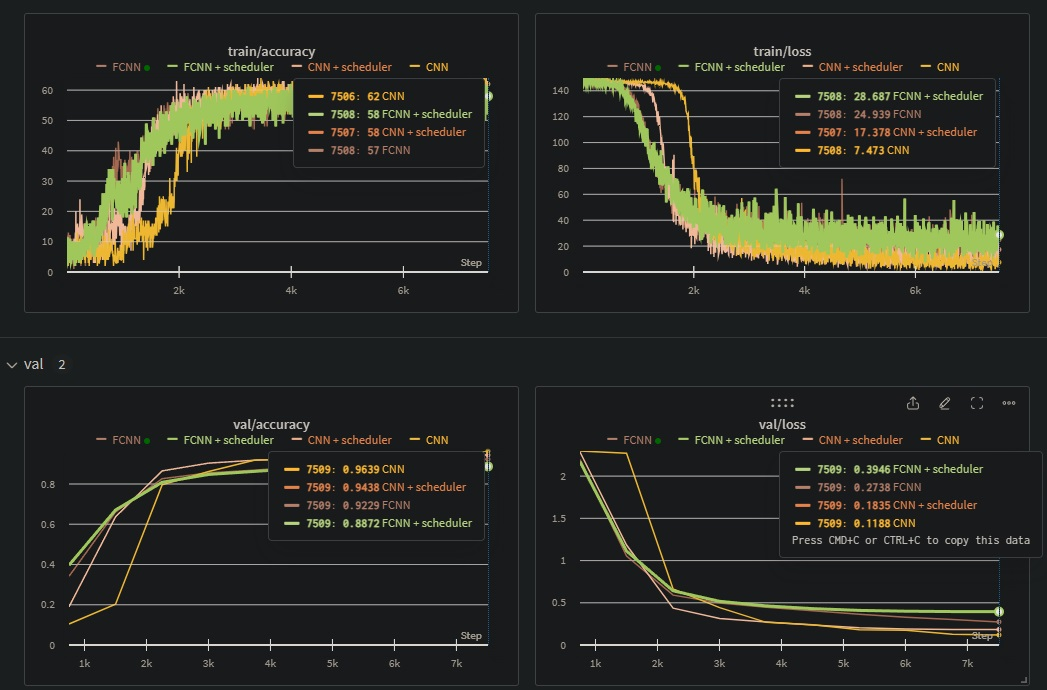

In [21]:
from IPython.display import Image
Image('results.jpg')